# Multiscale Migration Model

This notebook implements our model using `numpy`, `haversine`, and `pandas` (with `xlrd`). It has been tested to run on Python 3.6. To start, import the required libraries.



In [ ]:
%cd ~/GOS/
# These libraries are used later to supply mathematical calculations.
import numpy as np
import pandas as pd
from math import e
from haversine import haversine
import ipywidgets as widgets
from ipywidgets import *
# Visualizaton
import matplotlib
import matplotlib.pyplot as plt
import gos
%matplotlib inline
# Reduce some visual clutter by only printing ten rows at a time.
# This can be adjusted to match personal preferences.
pd.set_option("display.max_rows", 500)

In [ ]:
plt.style.use('ggplot')

The datasets used in the model are found in the `/data` subdirectory. Many are formatted as either CSV files or XLSX files.

In [ ]:
%ls ./examples/multiscale-migration/data

In [ ]:
skill = IntSlider(min=0, max=100, value=90)
display(skill)

The following shortcut functions helps locate these data files easily.

In [ ]:
def file_path(name):
    """
    Shortcut function to get the relative path to the directory
    which contains the data.
    """
    return "./examples/multiscale-migration/data/%s" % name

## Importing and cleaning the data.

In this step, we define some helper functions that will help all of our datasets talk to each other.

In [ ]:
column_names = ["Name", "Code"]

def country_codes():
    """
    Build country rows from their names, ISO codes, and Numeric
    Country Codes.
    """
    cc = (
        pd.read_csv(
            file_path(
                "Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
            usecols=[0, 2, 3],
            index_col=1,
            keep_default_na=False))
    #other_codes = pd.read_csv(file_path("other.csv"), index_col=1)
    
    #
    cc.columns = column_names
    #cc.index.rename("Name")
    return cc #pd.concat([cc, other_codes])

def other_codes():
    other_codes = pd.read_csv(file_path("other.csv"), index_col=1)
    other_codes.columns = column_names[0:1]
    return other_codes

In [ ]:
world = gos.World(index=set(country_codes().index) | set(other_codes().index))

In [ ]:
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Name"].apply(list).to_dict())
gos.Neighborhood.update(other_codes().groupby('ISO')["Name"].apply(list).to_dict())
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Code"].apply(list).to_dict())

## Importing Data

### Freedom Index

The [Freedom Index](https://freedomhouse.org/report/freedom-world/freedom-world-2017) comes from Freedom House. 

In [ ]:
def freedom_index():
    """
    Read data from the Freedom Index.
    """
    # TODO: Add xlrd to requirements.
    xl = pd.ExcelFile(file_path("Freedom_index.xlsx"))
    xl = xl.parse(1)
    xl.set_index("Country")
    return xl

fi = freedom_index().set_index("Country")
fi.columns = ["Freedom Index"]
fi.plot.hist(bins=10)
#print(len(fi))

## A/B Values

These values are used in the return to skill function. These values are based on each country's income distribution.

In [ ]:
def ab_values():
    """
    Read generated A/B values for each country.
    """
    return pd.read_excel(file_path("A&B values for RTS.xlsx")).T

ab = ab_values()
ab.plot.hist(subplots=True, sharex=False)

### Passport Index

The [Passport Index](https://www.cato.org/human-freedom-index) comes from Arton Capital. 

In [ ]:
def passport_index():
    """
    Read data from the Passport Index.
    """
    pi = pd.read_excel(file_path("PassportIndex.xlsx"))
    pi = pi.set_index("Country")
    pi.columns = ["Passport Index"]
    return pi

pi = passport_index()
pi.plot.hist()

## Unemployment

In [ ]:
unemployment_data = pd.read_csv(file_path("CIA_Unemployment.csv"), index_col=0, usecols=[1, 2])
unemployment_data["Unemployment"] /= 100
unemployment_data.plot.hist()

## Population

In [ ]:
# Population
population = pd.read_csv(file_path("newPOP.csv"))
population = population.set_index("Country")
population

In [ ]:
world.update_neighborhoods(ab)
world.update_neighborhoods(pi)
world.update_neighborhoods(unemployment_data)
world.update_neighborhoods(population)
world.update_neighborhoods(fi)

## Shared Language

Agents are assigned proficiency in languages spoken in their origin country. Moving to a country with entirely new languages presents a higher migration cost.

In [ ]:
lang_csv = pd.read_csv(file_path("languages.csv"), index_col=0)
lang_sets = [set([str(y).strip() for y in x[1] if y is not ' ']) for x in lang_csv.iterrows()]
overlap = []
for s in lang_sets:
    o = []
    for i in range(len(lang_sets)):
        o.append(len(lang_sets[i].intersection(s)) >= 1)
    overlap.append(o)
lang_data = pd.DataFrame(overlap, index=lang_csv.index, columns=lang_csv.index)
print(len(lang_data))
world.add_matrix("language", 1-lang_data)

## UN Migration History

In [ ]:
un_pd = pd.read_excel(
        file_path(
            "UN_MigrantStockByOriginAndDestination_2015.xlsx"
        ),
        skiprows=15
    )
un_pd = un_pd.set_index('Unnamed: 1')
un_pd = un_pd.iloc[0:275,7:250]

# TODO: Should we be using the UN numbers for this?
un_pd = un_pd.sort_index().fillna(1)
world.add_matrix("un", un_pd)

## Distance

The great circle distance between the average latitude and longitude of each country is used to determine distance between each pair of countries. A greater distance between countries corresponds to a greater cost of migration.

In [ ]:
distance_frame = pd.read_csv(
    file_path("Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
    usecols=[2,4,5],
    index_col=0,
    keep_default_na=False)
locations = [(x[1][0], x[1][1]) for x in distance_frame.iterrows()]
rows = []
for i in range(len(locations)):
    row = []
    for loc in locations:
        row.append(haversine(loc, locations[i]))
    rows.append(row)
distance = pd.DataFrame(rows, distance_frame.index, distance_frame.index)
world.add_matrix("distance", distance / distance.max().max())

## Calculate "RTS".

In [ ]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * skill.value)), "rts")

## Country Beta Values

In [ ]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * 30)), "beta")

## Freedom Index difference 
\begin{equation}
\frac{FI_D-FI_O}{100}
\end{equation}

In [ ]:
rows=[]
for i in range(len(world.data["Freedom Index"])):
    row = []
    for freedom_index in world.data["Freedom Index"]:
        diff=(freedom_index-(world.data["Freedom Index"][i]))/100.0
        row.append(diff)
    rows.append(row)
fi_diff = (pd.DataFrame(rows, world.data["Freedom Index"].index, world.data["Freedom Index"].index))
print(fi_diff)

## Political barriers
$$  PB = \delta_1 \frac{PIR_{D}}{100} +  \delta_2 (1-\frac{(FI_D-FI_O)}{100}) $$

In [ ]:
delta1=.5
delta2=.25
political_barriers=delta1*world.data["Passport Index"]/100.0 + delta2*(1 - fi_diff)
print(political_barriers)


In [ ]:
world.add_matrix("Political Barriers", political_barriers)

## Migration History 
\begin{equation} 
MH_{O\rightarrow D}\ = \gamma_1 (1-OM_{O\rightarrow D})\ + \gamma_2 (1-EE_{O\rightarrow D}) 
\end{equation}

\begin{equation} OM_{O\rightarrow D}\ = \frac {\text {migrants from origin in destination}} {\text {population of origin}} \end{equation}

\begin{equation} EE_{O\leftrightarrow D}\ = \frac {\text{migrants from origin in destination}} {\text {population of destination.}} \end{equation}

In [ ]:
gamma1=.5
gamma2=.5
OM=world.matrices['un'].sort_index(axis=1).sort_index(axis=0)/world.data['Population']
#transpose UN matrix for this calculation so that we are dividing by population of destination 
EE=world.matrices['un'].T.sort_index(axis=1).sort_index(axis=0)/world.data['Population']
EE=EE.T
MH=gamma1*(OM)+gamma2*(EE)
#print(MH)
max_MH = MH.max().nlargest(10).mean()
#print(max_MH)
MH = 1 - (MH/max_MH)
MH[MH<0] = 0
print(MH)

In [ ]:
world.add_matrix("Migration History", MH)

\begin{equation}
C = { \alpha_1 \frac{D_{O\leftrightarrow D}} {D_{Max}} + \alpha_2 MH_{O\rightarrow D}  + \alpha_3 L_{O\leftrightarrow D} + \alpha_4 PB}
\end{equation}

In [ ]:
# Cost
alpha1=.35
alpha2=.35
alpha3=.15
alpha4=.15
c = (alpha1*world.matrices["distance"] +
     alpha2*world.matrices["Migration History"] +
     alpha3*world.matrices["language"] +
     alpha4*world.matrices["Political Barriers"])
world.add_matrix("cost", c * world.data['beta'])

In [ ]:
gos.map_plot("Costs (SYR)", "Reds", world.matrices["cost"]["SYR"], matplotlib.colors.Normalize)

In [ ]:
gos.map_plot("Costs (FRA)", "Reds", world.matrices["cost"]["FRA"], matplotlib.colors.Normalize)

In [ ]:
world.update_neighborhoods((1 - world.data["Unemployment"]) * world.data["rts"], "wages")

In [ ]:
gos.map_plot("Wages", "Greens", world.data["wages"], matplotlib.colors.Normalize)

In [ ]:
#beta = world.data.rts.mean()
#beta = RTS_list.median()

world.add_matrix("migration", (pd.DataFrame(
    np.array(
        [[x] * len(world.data) for x in world.data["wages"].values]
    ) - np.array(
        [list(world.data["wages"].values)] * len(world.data)
    ),
    world.data.index,
    world.data.index
    )  - world.matrices["cost"]).clip_lower(0))
world.matrices["migration"] = world.matrices["migration"] / (world.matrices["migration"].sum() + 1)
world.matrices["migration"] = world.matrices["migration"] / world.matrices["migration"].sum(axis=1).max()

# TODO: Why does this require being transposed?
world.matrices["migration"] = (0.15 * world.matrices["migration"].transpose() * world.data["Population"]).transpose()

world.matrices["migration"]

In [ ]:
gos.map_plot(
    "Immigration Estimations (x={})".format(skill.value),
    'Greens',
    world.matrices["migration"].sum(axis=1)+1,
    matplotlib.colors.LogNorm)

In [ ]:
gos.map_plot(
    "Estimated Number of Emigrants (x={})".format(skill.value),
    'Reds',
    world.matrices["migration"].sum(),
    matplotlib.colors.Normalize
)

In [135]:
gos.map_plot(
    "Net Migration (x={})".format(skill.value),
    'coolwarm',
    world.matrices["migration"].sum(axis=1) - world.matrices["migration"].sum(),
    gos.MidPointNorm, sides=2)

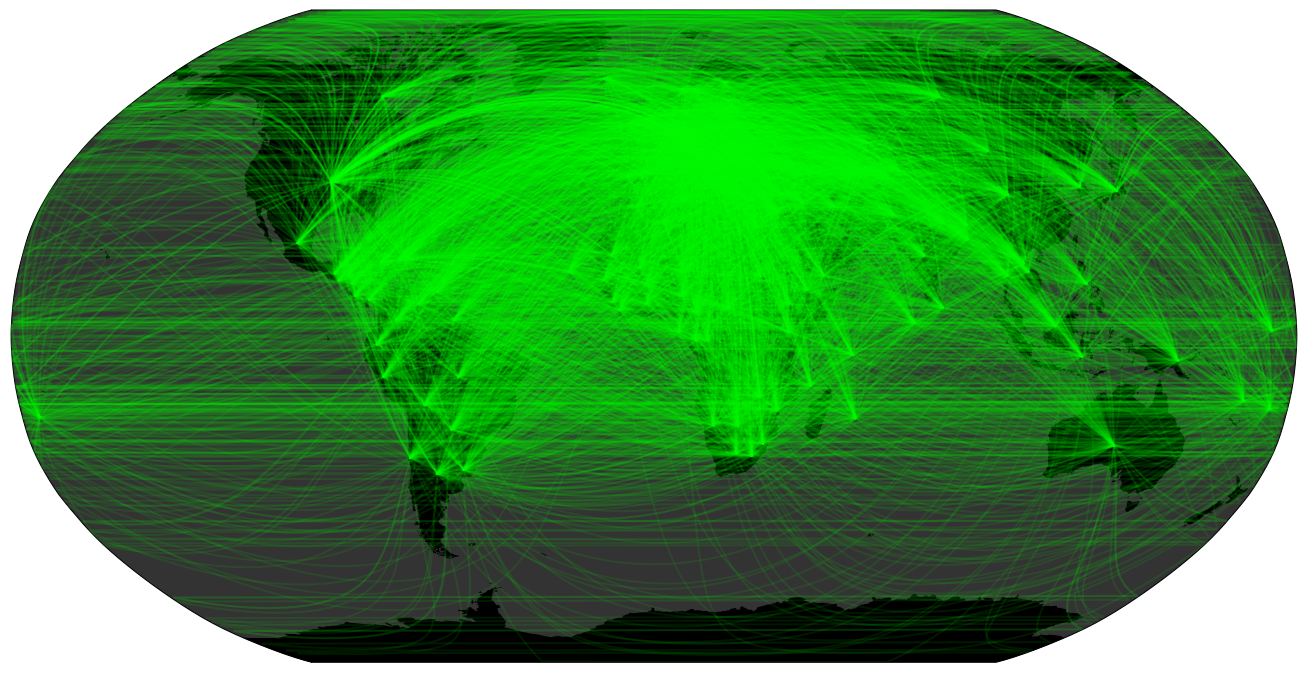

In [136]:
import numpy as np
from numpy import ma
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cbook
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm

COLOR1 = '#333333'
COLOR2 = '#000000'

def plot_lines(matrix):
    fix, ax = plt.subplots(figsize=(24, 12))
    m = Basemap(resolution='l',
               projection='robin',
               lon_0=0)

    m.drawmapboundary(fill_color=COLOR1)
    m.fillcontinents(color=COLOR2, lake_color=COLOR1)
    d = distance_frame[distance_frame.index.isin(world.data.index)]
    for _, x in d.iterrows():
        for _, y in d.iterrows():
            if matrix[x.name][y.name] > 0.5:
                m.drawgreatcircle(
                    x["Longitude (average)"],
                    x["Latitude (average)"],
                    y["Longitude (average)"],
                    y["Latitude (average)"],
                    linewidth=2,
                    color='#00FF00{:02X}'.format((int(25 + 100 * matrix[x.name][y.name] / matrix.max().max())))
                )
    #plt.savefig('linesfig.pdf', format='pdf', dpi=1000, transparent=True)
    return plt

plot_lines(world.matrices["migration"])